# **PROYECTO FINAL**

# **Problema 1 - Word Cloud:**

## Librerías:

In [1]:
import pandas as pd
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import random
from PIL import Image
import seaborn as sns
import stat
import contractions 

## Carga de Datos:

In [2]:
dataset = pd.read_csv('Datasets_P1/tw_source.csv', encoding='latin_1', header=None)
dataset.columns = ['index', 'id', 'fecha', 'query', 'usuario', 'tweet']

In [3]:
dataset.dropna(subset=['tweet'], inplace=True)

In [4]:
dataset.head()

,index,id,fecha,query,usuario,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Identificar top 3 menciones:

In [5]:
# Inicializar variables
lista_menciones = []
filas_per_at = {}
cont = 0

# Extraer las menciones y limpiar el texto
for tweet in dataset['tweet']:
    # Opción 1:
    # --> ats_in_tweet = [re.sub(r'[^\w@]', '', palabra) for palabra in tweet.split() if '@' in palabra]
    # Opción 2:
    ats_in_tweet = [re.sub(r'[^\w@]', '', palabra) for palabra in tweet.split() if '@' in palabra and len(palabra) > 1]

    # Añadir menciones a la lista global
    lista_menciones.extend(ats_in_tweet)
    
    try:
        ultimo_at = ats_in_tweet[-1]  # Obtenemos el último @ del tweet
        filas_per_at.setdefault(ultimo_at, []).append(cont)
    except:
        pass
    finally:
        cont += 1

# Contar las menciones
contador_menciones = Counter(lista_menciones)
# Opción 1:
# --> usuarios_mas_mencionados = contador_menciones.most_common(4)[1:]
# Opción 2:
usuarios_mas_mencionados = contador_menciones.most_common(3)  # Top 3 usuarios
usuarios_mas_mencionados

[('@mileycyrus', 4416), ('@tommcfly', 3873), ('@ddlovato', 3434)]

#### Explicación

- **`[^\w@]`** significa "cualquier cosa que **no** sea una letra, número o `@`".

- **`re.sub`**  Reemplaza cualquier cosa que coincida con `[^\w@]` por una cadena vacía (`''`), eliminando esos caracteres no deseados.

In [6]:
palabra = "@john_doe123$%^&*"
limpia_palabra = re.sub(r'[^\w@]', '', palabra)
print(limpia_palabra) 

@john_doe123


## Crear corpus:

In [7]:
# Inicializar un diccionario para almacenar los corpus de cada usuario
corpus_usuarios = {}

# Iterar sobre los usuarios más mencionados y crear el corpus
for usuario, _ in usuarios_mas_mencionados:
    filas_usuario = filas_per_at[usuario]
    corpus_usuario = dataset.iloc[filas_usuario][['id', 'fecha', 'tweet']].copy()
    corpus_usuario['length'] = corpus_usuario['tweet'].apply(len)
    
    # Restablecer el índice para eliminar la columna del índice
    corpus_usuario = corpus_usuario.reset_index(drop=True)
    
    # Almacenar el corpus en el diccionario
    corpus_usuarios[usuario] = corpus_usuario

corpus_usuarios['@mileycyrus'].head()

,id,fecha,tweet,length
0,1468063101,Mon Apr 06 23:30:57 PDT 2009,@mileycyrus hahaha dont be like that one time ...,107
1,1468286517,Tue Apr 07 00:45:20 PDT 2009,"@mileycyrus i have the same problem, but it's ...",137
2,1468297110,Tue Apr 07 00:49:07 PDT 2009,@mileycyrus I guess counting sheep didn't work...,72
3,1468298918,Tue Apr 07 00:49:44 PDT 2009,@mileycyrus I would too if it meant spending a...,100
4,1468318249,Tue Apr 07 00:56:41 PDT 2009,@mileycyrus AWWW u seriously have the cutest d...,112


## Remover stopwords, stemming y lemmatización:

#### Descargar recursos:

In [8]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aalva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aalva\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aalva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Inicialización:

In [9]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

#### Definición de stop_word:

In [10]:
stop_words = set(stopwords.words('english'))

#### Función:

In [11]:
extra_stopwords = ['mileycyrus', 'miley', 'tommcfly', 'tom', 'ddlovato', 'demi', 'xx', 'plea', 'haha']

In [12]:
def limpiar_texto_automatico(texto, min_word_length=2, min_word_frequency=1):
    # Expandir contracciones
    texto = contractions.fix(texto)

    # Convertir el texto a minúsculas
    texto = texto.lower()

    # Remover caracteres especiales (excepto emojis)
    texto = re.sub(r'[^\w\s]', '', texto)  

    # Tokenización
    tokens = nltk.word_tokenize(texto)

    # Remover stopwords, extra_stopwords, palabras cortas y menciones con '@'
    palabras_filtradas = [palabra for palabra in tokens 
                          if palabra not in stop_words 
                          and palabra not in extra_stopwords 
                          and len(palabra) >= min_word_length 
                          and '@' not in palabra]

    # Contar las palabras
    contador_palabras = Counter(palabras_filtradas)

    # Filtrar palabras según la frecuencia mínima
    palabras_filtradas = [palabra for palabra in palabras_filtradas 
                          if contador_palabras[palabra] >= min_word_frequency]

    # Aplicar lematización (sin stemming para preservar mejor el significado)
    palabras_lemmatizadas = [lemmatizer.lemmatize(palabra) for palabra in palabras_filtradas]

    # Unir palabras limpias en una cadena
    return ' '.join(palabras_lemmatizadas)

#### Aplicar limpieza:

In [13]:
# Aplicar la limpieza automática a los tweets
for usuario in corpus_usuarios:
    corpus_usuarios[usuario]['tweet_clean'] = corpus_usuarios[usuario]['tweet'].apply(
        lambda x: limpiar_texto_automatico(x, min_word_length=2, min_word_frequency=1))

# Mostrar el corpus limpio para un usuario específico
corpus_usuarios['@mileycyrus'].head()

,id,fecha,tweet,length,tweet_clean
0,1468063101,Mon Apr 06 23:30:57 PDT 2009,@mileycyrus hahaha dont be like that one time ...,107,hahaha like one time ny got 30 min sleep got s...
1,1468286517,Tue Apr 07 00:45:20 PDT 2009,"@mileycyrus i have the same problem, but it's ...",137,problem 443 let u see counting works123456 57 ...
2,1468297110,Tue Apr 07 00:49:07 PDT 2009,@mileycyrus I guess counting sheep didn't work...,72,guess counting sheep work hope get sleep
3,1468298918,Tue Apr 07 00:49:44 PDT 2009,@mileycyrus I would too if it meant spending a...,100,would meant spending day heaven wmy mom gettin...
4,1468318249,Tue Apr 07 00:56:41 PDT 2009,@mileycyrus AWWW u seriously have the cutest d...,112,awww seriously cutest dog sorry hope get sleep...


## Generar WorldCloud:

#### Función:

In [14]:
def generar_wordcloud(texto, usuario):
    # Contar las palabras
    palabras = texto.split()
    contador_palabras = Counter(palabras)
    
    # Obtener las 10 palabras más comunes
    top_10_palabras = dict(contador_palabras.most_common(10))
    
    # Crear el WordCloud solo con las 10 palabras más comunes
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_10_palabras)
    
    # Mostrar el WordCloud
    plt.figure(figsize=(6, 8))  # Aumentar el tamaño de la figura
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Eliminar los ejes
    plt.title(f'WordCloud para {usuario} (Top 10 palabras)', fontsize=16)
    plt.show()

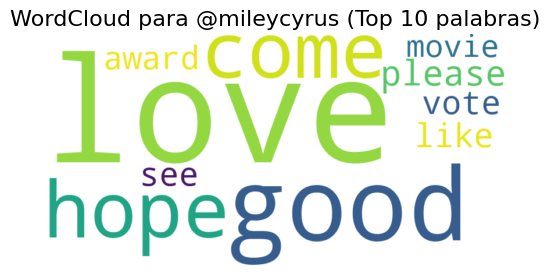

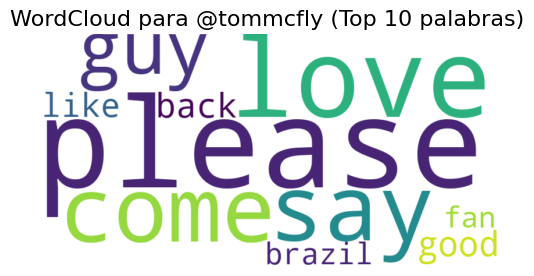

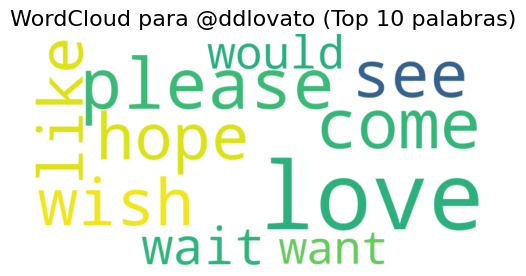

In [17]:
for usuario, corpus in corpus_usuarios.items():
    texto = ' '.join(corpus['tweet_clean'])
    generar_wordcloud(texto, usuario)

## Citas a los usuarios

Basándonos en los WordCloud generados para cada usuario, haremos un análisis del contexto y la razón por la que los mencionan con mayor frecuencia:

---

### 1. **@mileycyrus**:
   - **Palabras claves**: "love", "please", "good", "hope", "come", "vote", "movie", "award".
   - **Contexto**:
     - Los seguidores parecen mencionar a Miley Cyrus en un contexto de admiración y apoyo. La palabra "love" aparece como la más destacada, lo que indica que muchos tweets son mensajes de cariño o admiración hacia la artista.
     - Palabras como "please" y "vote" sugieren que algunos fans están solicitando algo, posiblemente votaciones para premios o apoyo en eventos.
     - "Award" y "movie" indican que los tweets también pueden estar relacionados con su carrera, particularmente en el ámbito de la actuación o los premios.
---

### 2. **@tommcfly**:
   - **Palabras claves**: "please", "love", "come", "say", "brazil", "fan", "good", "back".
   - **Contexto**:
     - Al igual que con Miley, "love" y "please" son palabras prominentes, lo que sugiere una interacción emocional con los fans, que probablemente estén pidiendo favores, respuestas, o simplemente expresando admiración.
     - La palabra "brazil" sugiere que los seguidores de Brasil están activos en las menciones a Tom, probablemente invitándolo a presentarse en ese país.
     - "Back" y "come" podrían estar relacionados con solicitudes para que vuelva a realizar algún evento o visita.
---

### 3. **@ddlovato**:
   - **Palabras claves**: "love", "please", "see", "hope", "wait", "wish", "come", "wish".
   - **Contexto**:
     - Nuevamente, "love" y "please" dominan el WordCloud, lo que sugiere que Demi Lovato es mencionada principalmente en un contexto afectivo.
     - Palabras como "hope", "wait", y "wish" indican que los seguidores pueden estar enviando mensajes de aliento o esperando alguna respuesta o acción por parte de Demi.
     - La palabra "wish" y "come" podría estar relacionada con el deseo de que la artista realice nuevamente algún evento o vista.
---

### Conclusión:

Para los tres usuarios, las menciones en los tweets están fuertemente influenciadas por la admiración y el apoyo de los seguidores. "Love" y "please" destacan en los tres casos, sugiriendo que la mayoría de las menciones provienen de interacciones afectuosas o de peticiones específicas, como votar en eventos o participar en actividades.